# Compute UMAPs outside of model training pipeline

Extract the key UMAP functions from the OOP framework so that I can compute for any data.

In [1]:
from os.path import join

from tqdm import tqdm

import matplotlib.pyplot as plt
import numpy as np
import torch
import polars as pl

from cytoself.analysis.analysis_opencell import AnalysisOpenCell
from cytoself.datamanager.opencell import DataManagerOpenCell
from cytoself.trainer.cytoselflite_trainer import CytoselfFullTrainer
from cytoself.trainer.utils.plot_history import plot_history_cytoself
from cytoself.analysis.utils.cluster_score import calculate_cluster_centrosize

/dgx1nas1/storage/data/jess/miniforge3/envs/cytoself/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
datapath = '/dgx1nas1/storage/data/jess/cytoself/varchamp_data/model_input'
outputpath = "/dgx1nas1/storage/data/jess/cytoself/trained_models/varchamp_v1"
model_nm = "model_28.pt"
data_ch = ['pro', 'nuc']
device="cuda:0"

model_path = f"{outputpath}/{model_nm}"

In [3]:
datamanager = DataManagerOpenCell(datapath, data_ch, fov_col=None)
datamanager.const_dataloader(batch_size=32, label_name_position=1)

Loading pro data...


100%|██████████| 1038/1038 [03:20<00:00,  5.18it/s]


Loading nuc data...


100%|██████████| 1038/1038 [03:17<00:00,  5.26it/s]


Loading label data...


100%|██████████| 1038/1038 [00:00<00:00, 2217.19it/s]


Splitting data...
Computing variance of training data...
Computing variance of validation data...
Computing variance of test data...


In [4]:
model_args = {
    "input_shape": (2, 100, 100),
    "emb_shapes": ((25, 25), (4, 4)),
    "output_shape": (2, 100, 100),
    "fc_output_idx": [2],
    "vq_args": {"num_embeddings": 512, "embedding_dim": 64},
    "num_class": len(datamanager.unique_labels),
    "fc_input_type": "vqvec",
}
train_args = {
    "lr": 0.0004,
    "max_epoch": 100,
    "reducelr_patience": 4,
    "reducelr_increment": 0.1,
    "earlystop_patience": 12,
}

In [5]:
trainer = CytoselfFullTrainer(train_args, homepath=outputpath, model_args=model_args)
trainer.load_model(model_path)

A model has been loaded from /dgx1nas1/storage/data/jess/cytoself/trained_models/varchamp_v1/model_28.pt


In [ ]:
# infer embeddings
test_embeddings = trainer.infer_embeddings(datamanager.DataLoader)

if isinstance(test_embeddings, tuple) and len(test_embeddings) > 1:
    test_embeddings = test_embeddings[0]

savepath_embeddings = trainer.savepath_dict["embeddings"]
np.save(join(savepath_embeddings, 'embeddings_testdata.npy'), test_embeddings)

In [85]:
# infer embeddings for training data 
train_embeddings = trainer.infer_embeddings(datamanager.train_loader)
if isinstance(train_embeddings, tuple) and len(train_embeddings) > 1:
    train_embeddings = train_embeddings[0]

savepath_embeddings = trainer.savepath_dict["embeddings"]
np.save(join(savepath_embeddings, 'embeddings_traindata.npy'), train_embeddings)


Infer: 100%|██████████| 22270/22270 [10:08<00:00, 36.61it/s]


In [ ]:
# save labels by data
train_labels = datamanager.train_loader.dataset.label
np.save(join(savepath_embeddings, 'labels_traindata.npy'), train_labels)

test_labels = datamanager.test_loader.dataset.label
np.save(join(savepath_embeddings, 'labels_testdata.npy'), test_labels)

In [7]:
import umap.umap_ as umap

n_neighbors=15
min_dist=0.1
metric='euclidean'
verbose=True

reducer = umap.UMAP(n_components=2, n_neighbors=n_neighbors, min_dist=min_dist, metric=metric, verbose=verbose)
umap_data = reducer.fit_transform(embedding_data.reshape(embedding_data.shape[0], -1))

UMAP( verbose=True)
Mon Jul 22 21:25:38 2024 Construct fuzzy simplicial set
Mon Jul 22 21:25:38 2024 Finding Nearest Neighbors
Mon Jul 22 21:25:38 2024 Building RP forest with 18 trees
Mon Jul 22 21:25:45 2024 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	 4  /  16
	Stopping threshold met -- exiting after 4 iterations
Mon Jul 22 21:26:01 2024 Finished Nearest Neighbor Search
Mon Jul 22 21:26:05 2024 Construct embedding


Epochs completed: 100%| ██████████ 200/200 [00:35]


Mon Jul 22 21:26:45 2024 Finished embedding


In [82]:
labels = datamanager.test_loader.dataset.label
umap_df = pl.DataFrame({
    "Metadata_Protein": list(labels[:, 0]),
    "Metadata_CellID": list(labels[:, 1]),
    "Comp1": umap_data[:, 0],
    "Comp2": umap_data[:, 1]
})
umap_df.write_parquet("/dgx1nas1/storage/data/jess/cytoself/trained_models/varchamp_v1/analysis/umap_data/umap_comps_testdata.parquet")

In [64]:
def get_custom_colormap(num_colors, first_color='#D3D3D3'):
    # Generate a colormap with the specified number of colors
    cmap = plt.cm.get_cmap('tab10', num_colors)
    colors = [mcolors.rgb2hex(cmap(i)) for i in range(num_colors)]
    # Replace the first color with light grey
    colors[0] = first_color
    return colors

In [79]:
gene = "LDHB"
umap_df = umap_df.with_columns(
    pl.when(pl.col("Metadata_Protein").str.contains(gene))
    .then(pl.col("Metadata_Protein"))
    .otherwise(pl.lit("000")).alias("Variant")
).sort("Variant")

import matplotlib.colors as mcolors
import matplotlib
num_colors = len(umap_df.select("Variant").to_series().unique().to_list())
cmap = get_custom_colormap(num_colors)

/tmp/ipykernel_30720/1670497697.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.


## Just plot UMAPs

In [3]:
import polars as pl
import matplotlib.colors as mcolors
import matplotlib
import matplotlib.pyplot as plt

In [4]:
umap_df = pl.read_parquet("/dgx1nas1/storage/data/jess/cytoself/trained_models/varchamp_v1/analysis/umap_data/umap_comps_testdata.parquet")

In [5]:
# Compute centroid of each WT
wt_centroid = umap_df.filter(~pl.col("Metadata_Protein").str.contains("-")).group_by("Metadata_Protein").agg([
    pl.col("Comp1").median().alias("Comp1"),
    pl.col("Comp2").median().alias("Comp2"),
])

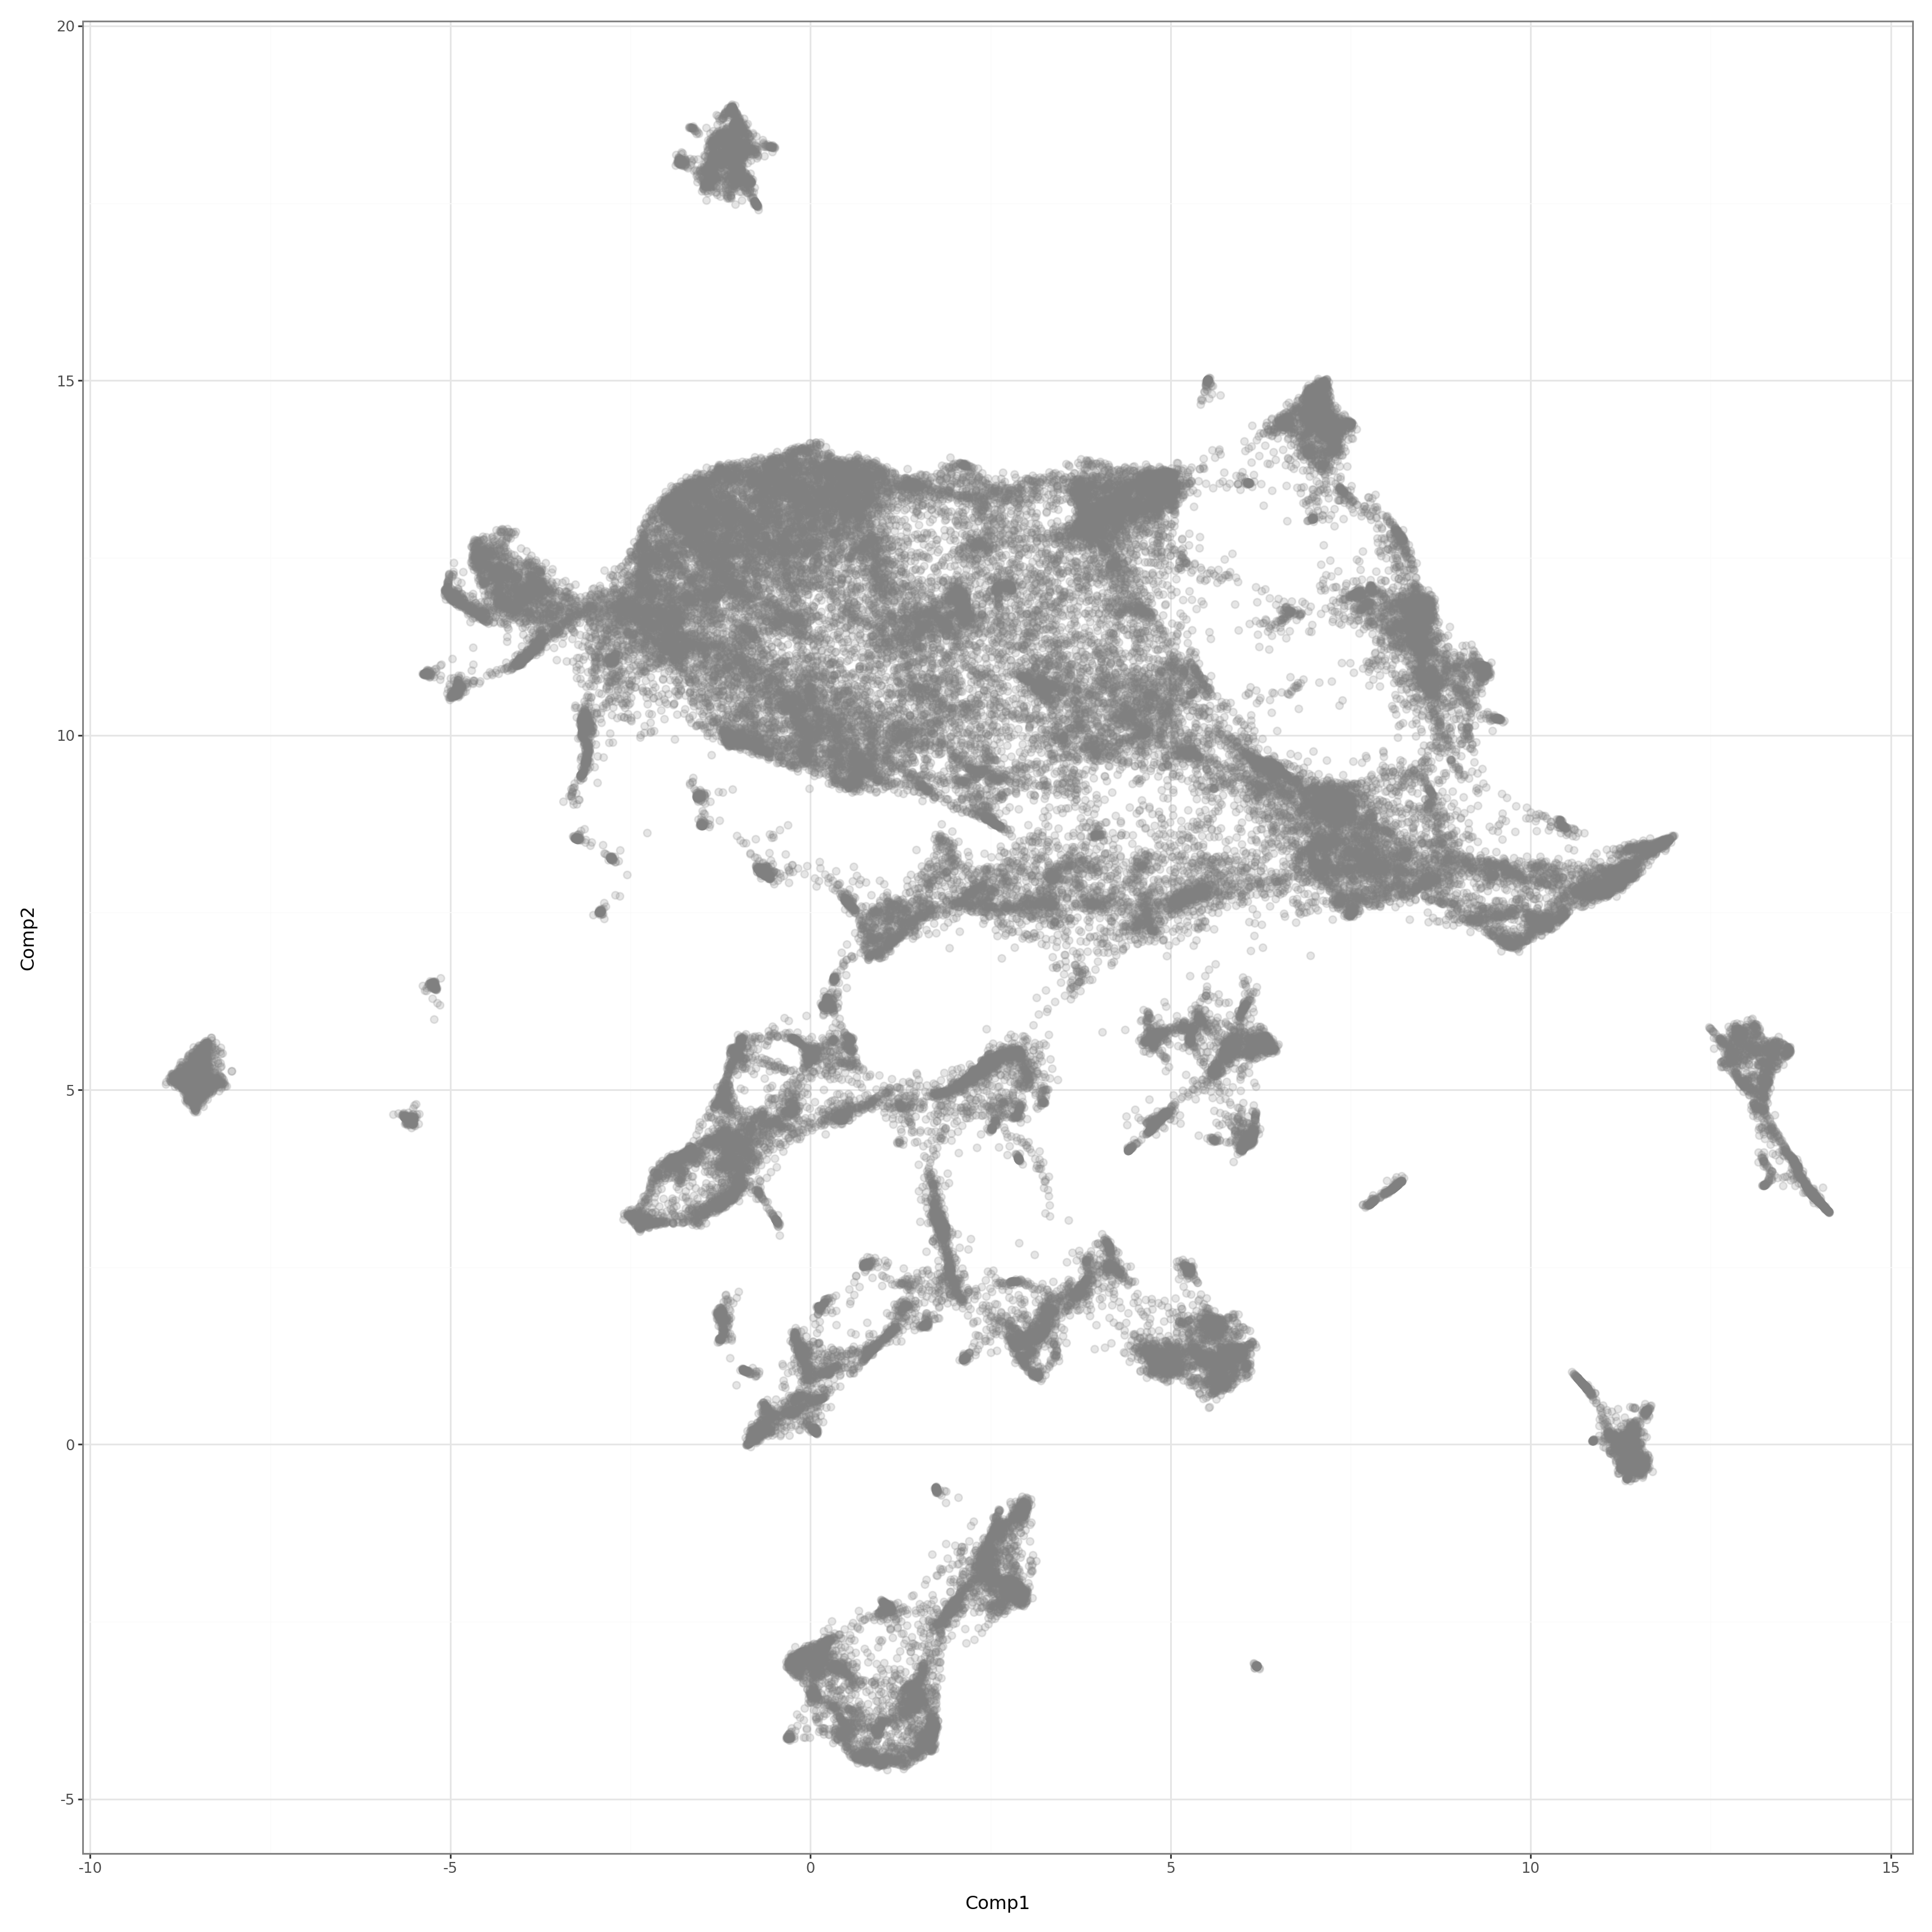

In [27]:
from plotnine import ggplot, aes, geom_point, theme_bw, ggtitle, scale_color_manual, geom_text
import plotnine as plotnine

plotnine.options.figure_size = (16,16)

adjust_text_dict = {
    'expand_points': (2, 2),
    #'force_text': (2,2),
    #'max_move': (5,5),
    'arrowprops': {
        'arrowstyle': '-',
        'color': 'red',
        'lw': 0.5,
    },
}

p = (ggplot() +
    geom_point(umap_df, aes(x = "Comp1", y = "Comp2"), color='grey',size=2, alpha=0.2) +
    #geom_text(wt_centroid, aes(x = "Comp1", y = "Comp2", label='Metadata_Protein'), color='black', fontweight='bold', size=10, adjust_text=adjust_text_dict) +
    #ggtitle("Centroids of WT alleles") + 
    theme_bw()
    )

p.show()

In [23]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from adjustText import adjust_text

plt.figure(figsize=(16, 16))
sns.kdeplot(data=umap_df.to_pandas(), x="Comp1", y="Comp2", fill=True, cmap="Greys", alpha=0.8, thresh=0, levels=100)

# Overlay the text labels
texts = []
for i, row in wt_centroid.to_pandas().iterrows():
    texts.append(plt.text(row["Comp1"], row["Comp2"], row["Metadata_Protein"], 
                          fontsize=8, fontweight='bold', color='black'))

# Adjust text to avoid overlaps
adjust_text(texts, expand_points=(2, 2), arrowprops=dict(arrowstyle='-', color='red', lw=0.5))
plt.title("Centroids of WT alleles")
plt.savefig("/dgx1nas1/storage/data/jess/cytoself/trained_models/varchamp_v1/analysis/umap_figures/umap_wt_centroid_density.svg", format='svg')


In [22]:
plt.savefig("/dgx1nas1/storage/data/jess/cytoself/trained_models/varchamp_v1/analysis/umap_figures/umap_wt_centroid_density.svg", format='svg')

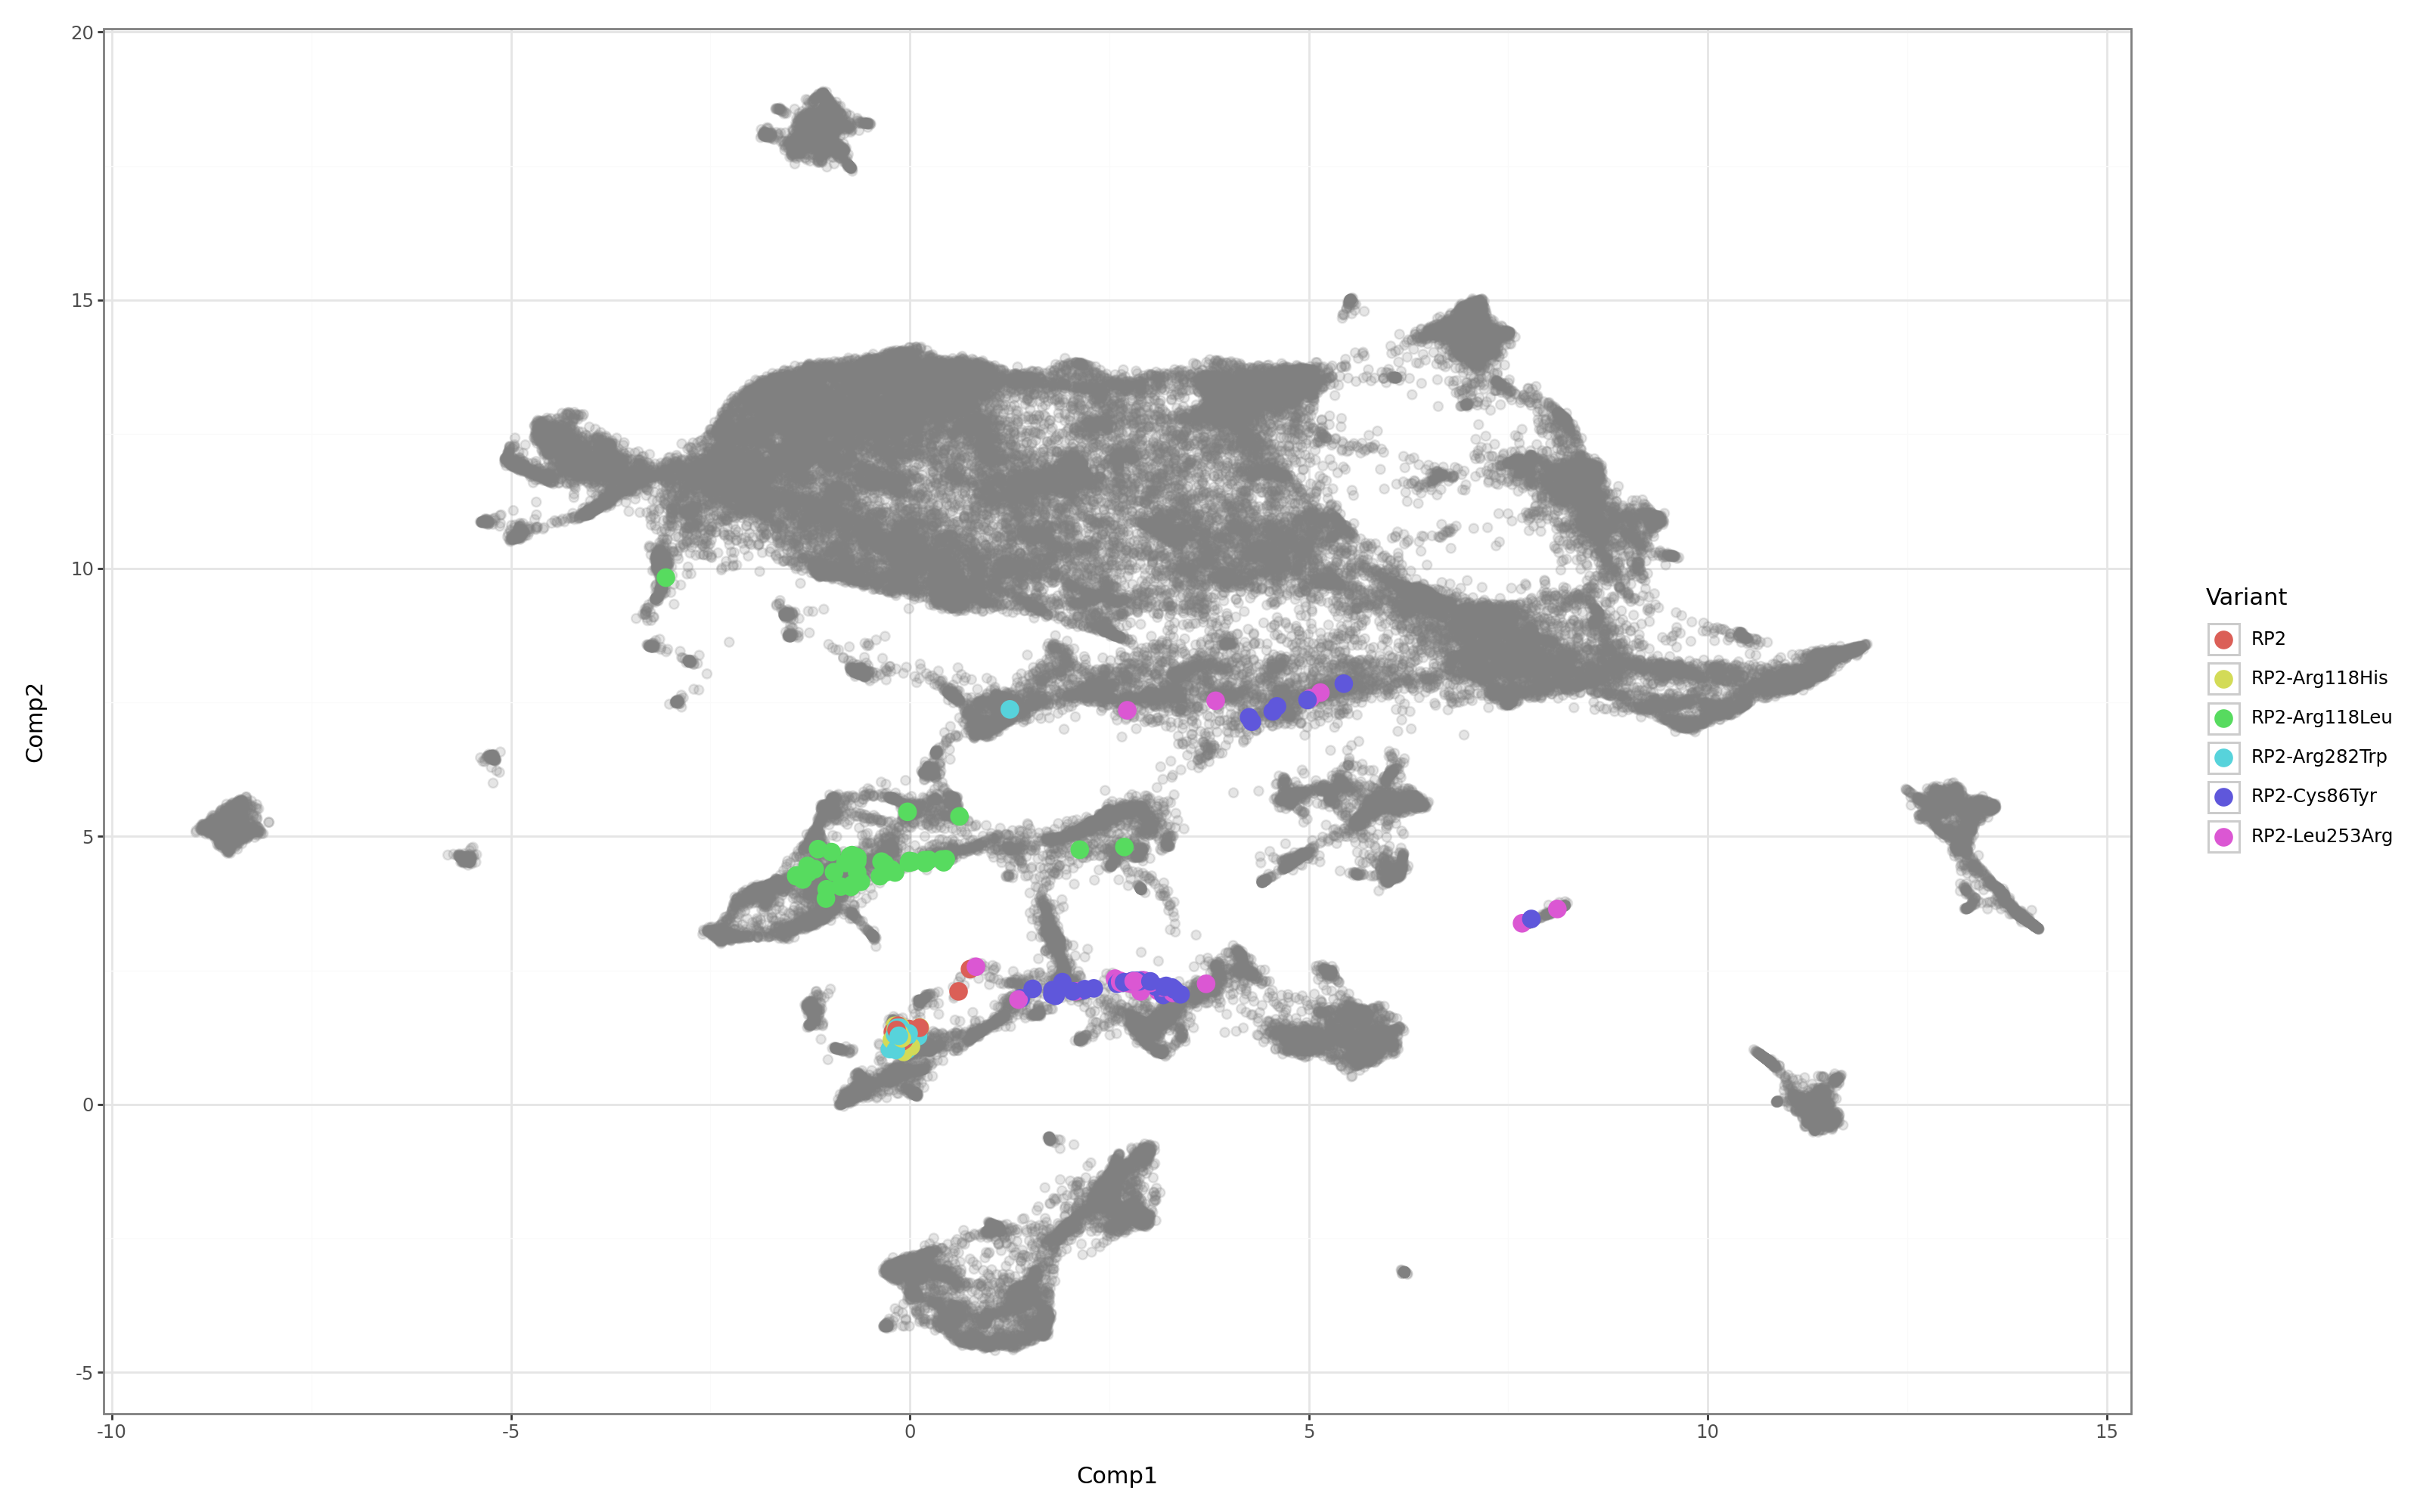

In [40]:
from plotnine import ggplot, aes, geom_point, theme_bw, ggtitle, scale_color_manual, geom_text, theme
import plotnine as plotnine

plotnine.options.figure_size = (16, 10)

gene = "RP2"
umap_df = umap_df.with_columns(
    pl.when(pl.col("Metadata_Protein").str.contains(gene))
    .then(pl.col("Metadata_Protein"))
    .otherwise(pl.lit("000")).alias("Variant")
).sort("Variant")

plot1 = (ggplot() +
         geom_point(umap_df.filter(pl.col("Variant") == "000"), aes(x = "Comp1", y = "Comp2"), color='grey', size=2, alpha=0.2) +
         geom_point(umap_df.filter(pl.col("Variant") != "000").sample(fraction=1.0, shuffle=True), aes(x = "Comp1", y = "Comp2", color='Variant'), size=4) +
         theme_bw()
         #+ theme(legend_position='none')
         )
plot1.show()

In [48]:
prot_count = umap_df.group_by("Metadata_Protein").agg(pl.count().alias("Frequency"))

Cool, illustrative examples:
- NCAT2: no significant mislocalization, we see spread of variants across large area. There is the interesting "island" - I wonder what these cells look like. Should extend my cell search and plot function for this group. 
- RP2: clear mislocalization of one variant. It obviously separates from the rest.
- MYOZ2: 3 variants, >80% all piled on top of eachother on one very small dot.
- LDHB: 1 variant clearly different


Next steps:
- Reproduce their cluster analysis with GO:CC and Corum complexes. Try implement the idea that I had for spatial enrichment. 
- Adapt pooled-rare plotting functions for the Varchamp data so that I can look up specific cells based on the UMAP location.
- Make comparable UMAPs with CellProfiler features: use all same QA/QC filters, plus downsample to ~10%